In [1]:
from tt.maxvol import maxvol
import numpy as np
import scipy
import scipy as sp

from scipy import sparse
from scipy import linalg
from matplotlib import pyplot as plt

from sklearn.neighbors import KDTree
from scipy.sparse import coo_matrix, csr_matrix

%matplotlib inline

In [2]:
def distance_matrix(block_size, format='coo'):
    ex = np.ones(block_size)
    T = sp.sparse.spdiags(np.vstack([ex, ex, ex]),
                          [1, 0, -1], block_size, block_size, format=format)
    return sp.sparse.kron(T, T, format=format)

def hilbert_traverse(size):
    x, y = np.mgrid[0:size, 0:size]
    data = list(zip(x.ravel(), y.ravel()))
    tree = KDTree(data, leaf_size=2)
    return np.array(tree.idx_array)

def conjugate(mat, permutation):
    mat_type = type(mat)
    mat_coo = sp.sparse.coo_matrix(mat)
    idr = np.argsort(permutation)
    mat_coo.row = permutation[mat_coo.row]
    mat_coo.col = permutation[mat_coo.col]
    return mat_type(mat_coo)

def conjugate_by_blocks(A, permutation):
    bs = A.shape[0] // permutation.size
    perm = np.repeat(permutation, bs)*bs + np.tile(np.arange(bs), permutation.size)
    A[:, :] = A[perm, :]
    A[:, :] = A[:, perm]

In [3]:
M = 5
R = 2**M
N = R**2
K = 32
BS = (N//K)

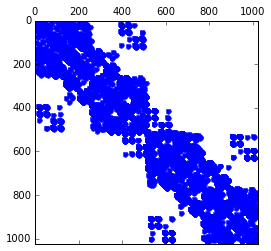

In [4]:
mat = distance_matrix(BS)
mat = conjugate(mat, hilbert_traverse(BS))
plt.spy(mat, marker='.')

In [5]:
def indices_from_shape(shape):
    return tuple((np.arange(dim) for dim in shape))

def break_indices(indices):
    m, n = indices[0].size, indices[1].size
    return ((indices[0][:m//2], indices[1][:n//2]), (indices[0][:m//2], indices[1][n//2:])),\
            ((indices[0][m//2:], indices[1][:n//2]), (indices[0][m//2:], indices[1][n//2:]))

def indices_unveil(indices):
    np.vstack([np.repeat(indices[0], indices[1].size),
               np.tile(indices[1], indices[0].size)]).T

def csvd(a, r=None):
    if r == None or r > min(a.shape):
        r = min(a.shape)
    u, s, v = np.linalg.svd(a, full_matrices=False)
    return u[:, :r], s[:r], v[:r]

In [36]:
class htree_node(object):
    def __init__(self, mat, pattern, indices, r=15, leaf_size=32):
        self.indices = indices
        self.low_rank = False
        if len(indices[0]) < leaf_size or len(indices[1]) < leaf_size:
            # block is small to partition
            ix = np.ix_(indices[0], indices[1])
            self.mat = mat[ix]
            self.is_leaf = True
            return
        if (pattern[indices[0], :][:, indices[1]].nnz == 0):
            ix = np.ix_(indices[0], indices[1])
            #self.u = mat[ix]
            u, s, v = csvd(mat[ix], r=r)
            self.u = u
            self.v = np.dot(np.diag(s), v)
            self.low_rank = True
            self.is_leaf = True
            return
        # we have non-leaf node
        self.is_leaf = False
        idxs = break_indices(self.indices)
        self.nw = htree_node(mat, pattern, idxs[0][0], r=r)
        self.ne = htree_node(mat, pattern, idxs[0][1], r=r)
        self.sw = htree_node(mat, pattern, idxs[1][0], r=r)
        self.se = htree_node(mat, pattern, idxs[1][1], r=r)

    def full_block(self, mat):
        if (self.is_leaf and self.low_rank):
            ix = np.ix_(self.indices[0], self.indices[1])
            mat[ix] = np.dot(self.u, self.v)
            #mat[ix] = self.u
        elif (self.is_leaf):
            ix = np.ix_(self.indices[0], self.indices[1])
            mat[ix] = self.mat
        else:
            self.nw.full_block(mat)
            self.ne.full_block(mat)
            self.sw.full_block(mat)
            self.se.full_block(mat)
    
    def matvec_part(self, vec, result):
        if (self.is_leaf and self.low_rank):
            result[self.indices[0]] += np.dot(np.dot(self.u, self.v), vec[self.indices[1]])
            #result[self.indices[1]] += np.dot(self.u, np.dot(self.v, vec[self.indices[1]]))
        elif (self.is_leaf):
            result[self.indices[0]] += np.dot(self.mat, vec[self.indices[1]])
        else:
            self.nw.matvec_part(vec, result)
            self.ne.matvec_part(vec, result)
            self.sw.matvec_part(vec, result)
            self.se.matvec_part(vec, result)
            
    def count_params(self):
        if (self.is_leaf and self.low_rank):
            return self.u.size + self.v.size
        elif (self.is_leaf):
            return self.mat.size
        else:
            return self.nw.count_params() + \
                self.ne.count_params() + \
                self.sw.count_params() + \
                self.se.count_params()
        
class htree(object):
    def __init__(self, mat, pattern, r=15, leaf_size=32):
        self.leaf_size = leaf_size
        self.pattern = pattern.copy()
        self.shape = mat.shape
        self.root = htree_node(mat,
                               scipy.sparse.csr.csr_matrix(pattern),
                               indices_from_shape(pattern.shape),
                               r=r,
                               leaf_size=leaf_size)
    def full_matrix(self):
        full_mat = np.zeros(self.shape)
        self.root.full_block(full_mat)
        return full_mat
    
    def count_params(self):
        return self.root.count_params()
    
    def matvec(self, vec):
        result = np.zeros_like(vec)
        self.root.matvec_part(vec, result)
        return result

In [10]:
def gen_mtx(n):
    modulo_range = np.linspace(0, 1, n)
    X, Y = np.meshgrid(modulo_range, modulo_range)
    with np.errstate(divide='ignore', invalid='ignore'):
        res = np.ones((n**2, n**2)) / np.abs(X.ravel()[:, np.newaxis] - Y.ravel()[np.newaxis, :])
        res[res == np.inf] = 0
        return res

Тут руками выставлен $r=16$,  который даёт хорошее приближение

In [37]:
A = gen_mtx(R)
conjugate_by_blocks(A, hilbert_traverse(BS))
ht = htree(A, mat, r=16)
AA = ht.full_matrix()
np.linalg.norm(A - AA) / np.linalg.norm(A)

2.8997114295081638e-15

In [12]:
1. * ht.count_params() / A.size

0.5078125

In [33]:
v = np.random.random(A.shape[0])

In [43]:
np.linalg.norm(ht.matvec(v) - np.dot(A, v)) / np.linalg.norm(np.dot(A, v))

6.3539129528665324e-16

array([ 1923.78616668,  2442.25375888,  1923.78616668, ...,  2048.49638523,
        2048.49638523,  2391.88000522])